<a href="https://colab.research.google.com/github/jimmYA-1995/GAN_practice/blob/master/GAN_for_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tensorflow-gpu==2.0.0

In [0]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from skimage.io import imshow
import matplotlib.pyplot as plt
from IPython.display import display

import tensorflow as tf
from tensorflow.keras import Model, layers, Sequential, datasets, optimizers
from tensorflow.keras.datasets import mnist, cifar10 



In [3]:
np.__version__, tf.__version__

('1.16.5', '2.0.0')

In [0]:
def get_datasets(source='mnist', data_size_ratio=1.):
  dataset = datasets.mnist if source=='mnist' else datasets.cifar10

  (x_train, y_train), (x_test, y_test) = dataset.load_data()
  train_size = int(x_train.shape[0] * data_size_ratio)
  test_size = int(x_test.shape[0] * data_size_ratio)
  
  x_train, y_train = x_train[:train_size], y_train[:train_size]
  x_test, y_test = x_test[:test_size], y_test[:test_size]
  
  

  print("Xdtype: {}, Ydtype: {}".format(x_train.dtype, y_train.dtype))
  print("Training: x={} y={}, Testing: x={} y={}".format(x_train.shape,
                                                         y_train.shape,
                                                         x_test.shape,
                                                         y_test.shape))

  return (x_train, y_train), (x_test, y_test)

In [5]:
(x_train, y_train), (x_test, y_test) = get_datasets(source='cifar10', data_size_ratio=1)

Xdtype: uint8, Ydtype: uint8
Training: x=(50000, 32, 32, 3) y=(50000, 1), Testing: x=(10000, 32, 32, 3) y=(10000, 1)


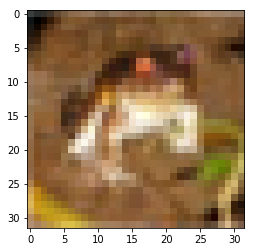

In [6]:
plt.figure()
plt.imshow(x_train[0])

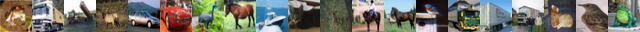

In [7]:
def showX(X):
    int_X_reshape = X.astype(np.uint8).reshape(-1,32,32,3).swapaxes(0,1).reshape(32,-1,3)
    display(Image.fromarray(int_X_reshape, mode='RGB'))

showX(x_train[:20])

## Test central crop

In [0]:
# print(x_train.shape)
# test = tf.image.central_crop(tf.convert_to_tensor(x_train), central_fraction=0.875)
# print(test.shape)
# plt.figure()
# plt.imshow(test[0])

## Build Tensorflow Dataset

In [0]:
def preprocess(x, y, crop=False):
  x = tf.cast(x, tf.float32) / 127.5 - 1 
  
  if crop:
    x = tf.image.central_crop(x, central_fraction=0.875) # 32 -> 28
#   x = tf.expand_dims(x, axis=-1)

  y = tf.one_hot(tf.squeeze(y,axis=-1), 10)
  
  return x, y

preprocessed_data = preprocess(x_train, y_train, crop=False)

BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 128

ds_train = tf.data.Dataset.from_tensor_slices(preprocessed_data)
ds_train = ds_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
a_batch = next(iter(ds_train))
a_batch[0].shape, tf.math.reduce_max(a_batch[0]), tf.math.reduce_min(a_batch[0]), a_batch[1].shape

(TensorShape([128, 32, 32, 3]),
 <tf.Tensor: id=31, shape=(), dtype=float32, numpy=1.0>,
 <tf.Tensor: id=33, shape=(), dtype=float32, numpy=-1.0>,
 TensorShape([128, 10]))

In [0]:
# ORIGINAL generator
# LATENT_DIM = 100
# class Generator(Model):
#   def __init__(self):
#     super().__init__()
#     self.fc1 = layers.Dense(8*8*256, use_bias=False, input_shape=(LATENT_DIM + 10,))
#     self.bn1 = layers.BatchNormalization()
#     # deConV layer
#     self.convtr_1 = layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding="SAME", use_bias=False)
#     self.bn2 = layers.BatchNormalization()
#     # deConV layer
#     self.convtr_2 = layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding="SAME", use_bias=False)
#     self.bn3 = layers.BatchNormalization()
#     # deConV layer
#     self.convtr_3 = layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding="SAME", activation="tanh")
    
#   @tf.function
#   def call(self, inputs, is_training=False):
#     x = layers.concatenate([inputs[0], inputs[1]]) # bs, latent_dim+10
#     x = self.fc1(x)
#     x = self.bn1(x, training=is_training)
#     x = tf.nn.leaky_relu(x)
#     x = tf.reshape(x, shape=[-1,8,8,256])
#     x = self.convtr_1(x) # bs, 7, 7, 3, 128
#     x = self.bn2(x, training=is_training)
#     x = tf.nn.leaky_relu(x)
#     x = self.convtr_2(x) # bs, 14, 14, 3, 64
#     x = self.bn3(x, training=is_training)
#     x = tf.nn.leaky_relu(x)
    
#     x = self.convtr_3(x) # bs, 28, 28, 3, 1(gray_scale)
    
#     return x

In [0]:
# ORIGINAL Discriminator
# class Discriminator(Model):
#   def __init__(self):
#     super().__init__()
#     self.conv1 = layers.Conv2D(64, (5,5), strides=(2,2), padding="SAME")
#     self.drop1 = layers.Dropout(0.3)
#     self.conv2 = layers.Conv2D(128, (5,5), strides=(2,2), padding="SAME")
#     self.drop2 = layers.Dropout(0.3)
#     self.flatten = layers.Flatten()
#     self.fc1 = layers.Dense(50)
#     self.bn = layers.BatchNormalization()
#     self.fc2 = layers.Dense(1)
#   @tf.function 
#   def call(self, inputs, is_training=False):
#     x = self.conv1(inputs[0]) # bs, 14, 14, 64
#     x = tf.nn.leaky_relu(x)
#     x = self.drop1(x, training=is_training)
#     x = self.conv2(x) # bs, 7, 7, 128
#     x = tf.nn.leaky_relu(x)
#     x = self.drop2(x, training=is_training)
#     x = self.flatten(x)
#     # input(x.shape)
#     x = layers.concatenate([x, inputs[1]]) # bs, 7x7x128+10
#     x = self.fc1(x) # bs, 50
#     x = self.bn(x, training=is_training)
#     x = tf.nn.leaky_relu(x)
#     x = self.fc2(x) # bs, 1
    
#     return x

In [0]:
# # Define generator
LATENT_DIM = 100
class Generator(Model):
  def __init__(self):
    super().__init__()
    self.fc1 = layers.Dense(8*8*128, input_shape=(LATENT_DIM + 10,))
    self.bn = [layers.BatchNormalization(momentum=0.9) for _ in range(7)]
    self.leaky_relu = [layers.LeakyReLU(alpha=0.1) for _ in range(7)]
    
    self.convtr = [layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding="SAME") for _ in range(2)]
    self.conv1 = layers.Conv2D(128, (4,4), strides=(1,1), padding="SAME")
    self.conv2 = layers.Conv2D(128, (5,5), strides=(1,1), padding="SAME")
    self.conv3 = layers.Conv2D(128, (5,5), strides=(1,1), padding="SAME")
    self.conv4 = layers.Conv2D(128, (5,5), strides=(1,1), padding="SAME")
    self.conv5 = layers.Conv2D(3, (5,5), strides=(1,1), padding="SAME", activation="tanh")
    
  @tf.function
  def call(self, inputs, is_training=False):
    x = layers.concatenate([inputs[0], inputs[1]]) # bs, latent_dim+10
    x = self.fc1(x)
    x = self.bn[0](x, training=is_training)
    x = self.leaky_relu[0](x)
    x = tf.reshape(x, shape=[-1,8,8,128])

    x = self.conv1(x)
    x = self.bn[1](x, training=is_training)
    x = self.leaky_relu[1](x)

    x = self.convtr[0](x) 
    x = self.bn[2](x, training=is_training)
    x = self.leaky_relu[2](x)

    x = self.conv2(x)
    x = self.bn[3](x, training=is_training)
    x = self.leaky_relu[3](x)

    x = self.convtr[1](x) 
    x = self.bn[4](x, training=is_training)
    x = self.leaky_relu[4](x)

    x = self.conv3(x)
    x = self.bn[5](x, training=is_training)
    x = self.leaky_relu[5](x)

    x = self.conv4(x)
    x = self.bn[6](x, training=is_training)
    x = self.leaky_relu[6](x)
    
    x = self.conv5(x)
    
    return x

In [0]:
# DEFINE Discriminator
class Discriminator(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = layers.Conv2D(128, (3,3), strides=(1,1), padding="SAME")
    self.conv2 = layers.Conv2D(128, (4,4), strides=(2,2), padding="SAME")
    self.conv3 = layers.Conv2D(128, (4,4), strides=(2,2), padding="SAME")
    self.conv4 = layers.Conv2D(128, (4,4), strides=(2,2), padding="SAME")

    self.bn = [layers.BatchNormalization(momentum=0.9) for _ in range(4)]
    self.leaky_relu = [layers.LeakyReLU(alpha=0.1) for _ in range(5)]

    self.flatten = layers.Flatten()
    self.fc1 = layers.Dense(512)
    self.fc2 = layers.Dense(1, activation='sigmoid')

  @tf.function 
  def call(self, inputs, is_training=False):
    x = self.conv1(inputs[0])
    x = self.bn[0](x, training=is_training)
    x = self.leaky_relu[0](x)

    x = self.conv2(x)
    x = self.bn[1](x, training=is_training)
    x = self.leaky_relu[1](x)

    x = self.conv3(x)
    x = self.bn[2](x, training=is_training)
    x = self.leaky_relu[2](x)

    x = self.conv4(x)
    x = self.bn[3](x, training=is_training)
    x = self.leaky_relu[3](x)

    x = self.flatten(x)
    x = layers.concatenate([x, inputs[1]])
    x = self.fc1(x) # bs, 512
    x = self.leaky_relu[4](x)
    x = self.fc2(x) # bs, 1
    
    return x

In [0]:
generator = Generator()
discriminator = Discriminator()
generator.build(input_shape=[(None,LATENT_DIM),(None,10)])
discriminator.build(input_shape=[(None,32,32,3),(None,10)])

In [0]:
  # Define both loss function
def generator_loss(generated_output):
  return tf.reduce_mean(tf.losses.binary_crossentropy(tf.ones_like(generated_output), generated_output, from_logits=True))

In [0]:
def discriminator_loss(real_output, generated_output, flip_label=True, soft_label=True):
  if soft_label:
    real_label = tf.random.uniform(real_output.shape, 0.8, 1.0)
    gen_label = tf.random.uniform(generated_output.shape, 0., 0.2)
  
  if flip_label:
    a = tf.random.uniform(real_label.shape, 0.0, 1.0)
    indices = tf.where(a < 0.05)
    updates = 1 - tf.gather_nd(real_label, indices)
    real_label = tf.tensor_scatter_nd_update(real_label, indices, updates)

    b = tf.random.uniform(real_label.shape, 0.0, 1.0)
    indices = tf.where(a < 0.05)
    updates = 1 - tf.gather_nd(gen_label, indices)
    gen_label = tf.tensor_scatter_nd_update(gen_label, indices, updates)

  real_loss = tf.reduce_mean(tf.losses.binary_crossentropy(real_label, real_output, from_logits=True))
  generated_loss = tf.reduce_mean(tf.losses.binary_crossentropy(gen_label, generated_output, from_logits=True))

#   total_loss = real_loss + generated_loss

  return real_loss, generated_loss

In [0]:
generator_optimizer = optimizers.Adam(lr=2e-4, beta_1=0.5)
discriminator_optimizer = optimizers.Adam(3e-4)

In [0]:
EPOCHS = 50
num_examples_to_generate = 20

# reuse this vector
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 LATENT_DIM])
condition_vector_generation = tf.one_hot(list(range(10))+list(range(10)), 10)

metrics = {}
metrics['train_Gloss'] = tf.keras.metrics.Mean('generator_loss', dtype=tf.float32)
metrics['train_Dloss_real'] = tf.keras.metrics.Mean('discriminator_loss_real', dtype=tf.float32)
metrics['train_Dloss_gen'] = tf.keras.metrics.Mean('discriminator_loss_gen', dtype=tf.float32)

In [0]:
@tf.function
def train_step(images, labels, print_loss=False):
  noise = tf.random.normal([labels.shape[0], LATENT_DIM]) # handle remainder
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape_real, tf.GradientTape() as disc_tape_gen :
    generated_images = generator([noise, labels], is_training=True)

    real_output = discriminator([images, labels], is_training=True)
    generated_output = discriminator([generated_images, labels], is_training=True)

    gen_loss = generator_loss(generated_output)
    disc_loss_real, disc_loss_gen = discriminator_loss(real_output, generated_output)
    if print_loss:
      print("[Sample LOSS] gen:{} disc_real:{} disc_gen:{}".format(gen_loss, disc_loss_real, disc_loss_gen))

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator_real = disc_tape_real.gradient(disc_loss_real, discriminator.trainable_variables)
  gradients_of_discriminator_gen = disc_tape_gen.gradient(disc_loss_gen, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator_real, discriminator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator_gen, discriminator.trainable_variables))
    
  metrics['train_Gloss'](gen_loss)
  metrics['train_Dloss_real'](disc_loss_real)
  metrics['train_Dloss_gen'](disc_loss_gen)

In [0]:
def plot_numBar(images):
  images = np.uint8(images*127.5+128).clip(0, 255)
  concat_image = np.transpose(images, [1,0,2,3]).reshape((32,-1,3))
  display(Image.fromarray(concat_image))

[Sample LOSS] gen:Tensor("Mean_1:0", shape=(), dtype=float32) disc_real:Tensor("Mean_3:0", shape=(), dtype=float32) disc_gen:Tensor("Mean_5:0", shape=(), dtype=float32)
[Sample LOSS] gen:Tensor("Mean_1:0", shape=(), dtype=float32) disc_real:Tensor("Mean_3:0", shape=(), dtype=float32) disc_gen:Tensor("Mean_5:0", shape=(), dtype=float32)
[Sample LOSS] gen:Tensor("Mean_1:0", shape=(), dtype=float32) disc_real:Tensor("Mean_3:0", shape=(), dtype=float32) disc_gen:Tensor("Mean_5:0", shape=(), dtype=float32)
[Sample LOSS] gen:Tensor("Mean_1:0", shape=(), dtype=float32) disc_real:Tensor("Mean_3:0", shape=(), dtype=float32) disc_gen:Tensor("Mean_5:0", shape=(), dtype=float32)
Epoch(42.08 sec): 0, gen_loss: 0.8238825798034668, disc_loss_for_real: 0.7368526458740234, disc_loss_for_gen: 0.6536245346069336


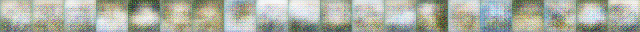

Epoch(30.45 sec): 1, gen_loss: 0.7092125415802002, disc_loss_for_real: 0.677261471748352, disc_loss_for_gen: 0.6936718225479126


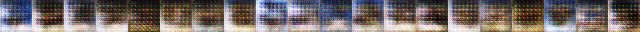

Epoch(30.13 sec): 2, gen_loss: 0.7156385183334351, disc_loss_for_real: 0.6906857490539551, disc_loss_for_gen: 0.6872912645339966


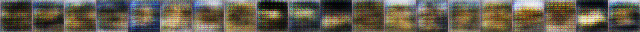

Epoch(30.18 sec): 3, gen_loss: 0.7151708006858826, disc_loss_for_real: 0.6778059601783752, disc_loss_for_gen: 0.6898372769355774


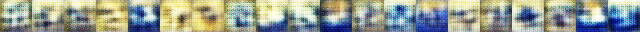

Epoch(30.14 sec): 4, gen_loss: 0.7101801633834839, disc_loss_for_real: 0.6906296610832214, disc_loss_for_gen: 0.6900337338447571


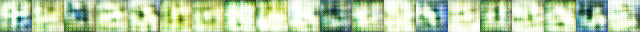

Epoch(30.26 sec): 5, gen_loss: 0.699447512626648, disc_loss_for_real: 0.6880097985267639, disc_loss_for_gen: 0.6956306099891663


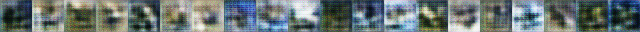

Epoch(30.23 sec): 6, gen_loss: 0.7065759301185608, disc_loss_for_real: 0.6877825260162354, disc_loss_for_gen: 0.6910544633865356


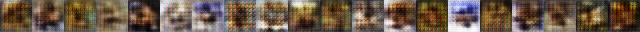

Epoch(30.21 sec): 7, gen_loss: 0.7040949463844299, disc_loss_for_real: 0.6879615187644958, disc_loss_for_gen: 0.6922996640205383


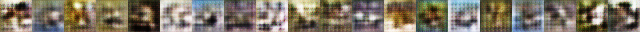

Epoch(30.12 sec): 8, gen_loss: 0.7011503577232361, disc_loss_for_real: 0.6912584900856018, disc_loss_for_gen: 0.6930902600288391


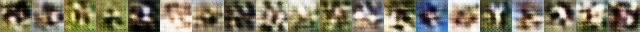

Epoch(30.30 sec): 9, gen_loss: 0.6990863680839539, disc_loss_for_real: 0.6906998753547668, disc_loss_for_gen: 0.6940020322799683


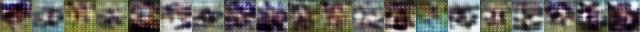

Epoch(30.20 sec): 10, gen_loss: 0.6936292052268982, disc_loss_for_real: 0.6863383054733276, disc_loss_for_gen: 0.6986656188964844


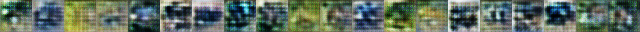

Epoch(30.25 sec): 11, gen_loss: 0.6925755739212036, disc_loss_for_real: 0.6899920105934143, disc_loss_for_gen: 0.6979345679283142


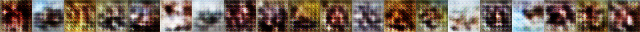

Epoch(30.16 sec): 12, gen_loss: 0.6978341937065125, disc_loss_for_real: 0.6913007497787476, disc_loss_for_gen: 0.6940224766731262


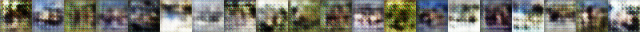

Epoch(30.13 sec): 13, gen_loss: 0.6982403993606567, disc_loss_for_real: 0.6899968981742859, disc_loss_for_gen: 0.6939722299575806


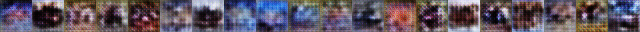

Epoch(30.21 sec): 14, gen_loss: 0.7038957476615906, disc_loss_for_real: 0.6907554864883423, disc_loss_for_gen: 0.6902534365653992


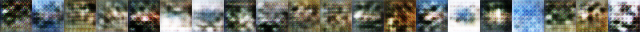

Epoch(30.15 sec): 15, gen_loss: 0.6997617483139038, disc_loss_for_real: 0.6925864219665527, disc_loss_for_gen: 0.6928921937942505


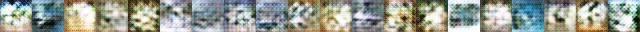

Epoch(30.14 sec): 16, gen_loss: 0.700408399105072, disc_loss_for_real: 0.6930141448974609, disc_loss_for_gen: 0.6918440461158752


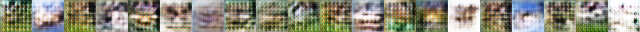

Epoch(30.12 sec): 17, gen_loss: 0.7003671526908875, disc_loss_for_real: 0.6942484974861145, disc_loss_for_gen: 0.6915580034255981


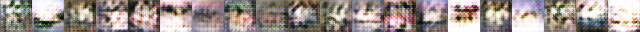

Epoch(30.04 sec): 18, gen_loss: 0.6975418925285339, disc_loss_for_real: 0.6908926963806152, disc_loss_for_gen: 0.6934128999710083


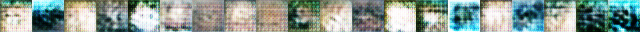

Epoch(29.99 sec): 19, gen_loss: 0.6970877647399902, disc_loss_for_real: 0.6908357739448547, disc_loss_for_gen: 0.6935005784034729


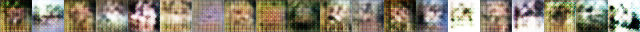

Epoch(30.00 sec): 20, gen_loss: 0.695695161819458, disc_loss_for_real: 0.6908405423164368, disc_loss_for_gen: 0.6956301927566528


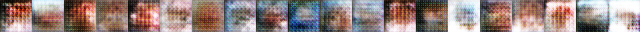

Epoch(30.06 sec): 21, gen_loss: 0.7094991207122803, disc_loss_for_real: 0.6890922784805298, disc_loss_for_gen: 0.6875146627426147


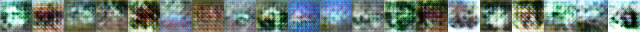

Epoch(30.13 sec): 22, gen_loss: 0.7064695358276367, disc_loss_for_real: 0.6912051439285278, disc_loss_for_gen: 0.6882074475288391


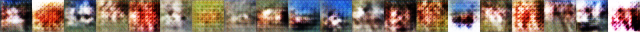

Epoch(29.97 sec): 23, gen_loss: 0.7016648650169373, disc_loss_for_real: 0.6906300187110901, disc_loss_for_gen: 0.6916763782501221


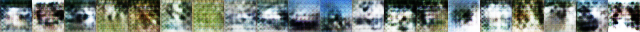

Epoch(30.12 sec): 24, gen_loss: 0.7020909190177917, disc_loss_for_real: 0.6931989789009094, disc_loss_for_gen: 0.6913770437240601


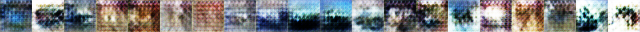

Epoch(30.07 sec): 25, gen_loss: 0.6965685486793518, disc_loss_for_real: 0.6899018287658691, disc_loss_for_gen: 0.694301962852478


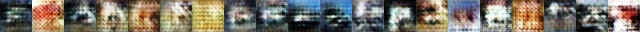

Epoch(30.07 sec): 26, gen_loss: 0.696492075920105, disc_loss_for_real: 0.6908057928085327, disc_loss_for_gen: 0.6945642828941345


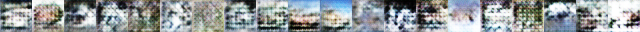

Epoch(30.19 sec): 27, gen_loss: 0.6969841718673706, disc_loss_for_real: 0.6918741464614868, disc_loss_for_gen: 0.6934872269630432


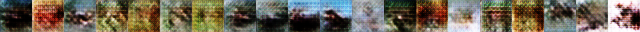

Epoch(30.13 sec): 28, gen_loss: 0.6992830634117126, disc_loss_for_real: 0.690980076789856, disc_loss_for_gen: 0.6929467916488647


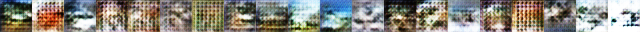

Epoch(30.17 sec): 29, gen_loss: 0.6955190300941467, disc_loss_for_real: 0.6913058757781982, disc_loss_for_gen: 0.6946196556091309


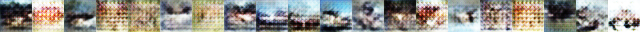

In [22]:
PATH = 'cifar10/exp1'
train_log_dir = 'logs/{}/'.format(PATH)
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

for epoch in range(EPOCHS):
  start_time = time.time()

  for i, (images, labels ) in enumerate(ds_train):
    print_loss=True if i == 0 else False
    train_step(images, labels, print_loss=print_loss)
  
  with train_summary_writer.as_default():
     tf.summary.scalar('GLoss', metrics['train_Gloss'].result(), step=epoch)
     tf.summary.scalar('DLoss_real', metrics['train_Dloss_real'].result(), step=epoch)
     tf.summary.scalar('DLoss_gen', metrics['train_Dloss_gen'].result(), step=epoch)

  template = 'Epoch({:.2f} sec): {}, gen_loss: {}, disc_loss_for_real: {}, disc_loss_for_gen: {}'      
  print(template.format(time.time()-start_time, epoch, metrics['train_Gloss'].result(), metrics['train_Dloss_real'].result(), metrics['train_Dloss_gen'].result()))
  fake = generator([random_vector_for_generation, condition_vector_generation], is_training=False)
  plot_numBar(fake)
    
  metrics['train_Gloss'].reset_states()
  metrics['train_Dloss_real'].reset_states()
  metrics['train_Dloss_gen'].reset_states()

In [0]:
# MODEL_PATH = 'models/cifar10_GAN/alldata'
# generator.save_weights(MODEL_PATH, save_format='tf')

In [0]:
# # load & use model
# new_model = Generator()
# new_model.build(input_shape=[(None,LATENT_DIM),(None,10)])
# noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
# image, label = next(iter(ds_train))

# # before load weights
# bad_images = new_model([noise, label], is_training=True)
# plot_numBar(bad_images)

In [0]:
# new_model.load_weights(MODEL_PATH)

# my_label = list([3,3,2,2,8,8,9,9,0,0])
# noise = tf.random.normal([len(my_label), LATENT_DIM])
# my_label = tf.one_hot(my_label, 10)

# better = new_model([noise, my_label])

# plot_numBar(better)